*Load packages and data:*

In [1]:
%run stdPackages.ipynb
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'0_GlobalData.xlsx'), read)
readSets(db)

# The ```mBasic``` model

### **The model**

The class specifies the simple linear electricity system model specified as:
<a id='simplemodel'>
$$\begin{align} \tag{1}
    \min \text{SystemCosts} &= \sum_{id}mc_{id} E_{id} \\ 
               \text{Load} &= \sum_{id} E_{id} \\ 
               E_{id}&\in[0,q_{id}], && \text{for all }id. 
\end{align}$$

This model minimizes the system costs of satisfying a given level of demand (Load) by supply $(E_{id})$ from different producers at the cost $mc_{id}$. Each producer can at most produce $q_{id}$. The relevant parameters for the model example are pre-loaded to the database ```db```. The database uses the name definitions: $E_{id}$ = ```'Generation'``` and $q_{id}$ = ```'GeneratingCapacity'```.

### **Augmented form LP**

To solve the model, the algorithm in ```scipy.optimize.linprog``` requires that we specify the problem in the 'augmented'form that specifically looks as follows:
$$\begin{align} \tag{2}
    &\min_{x}\mbox{ }c^T\cdot x \\ 
    &A_{ub}\times x \leq b_{ub} \\ 
    &A_{eq}\times x  = b_{eq} \\ 
    &l\leq x\leq u,
\end{align}$$
where 
* $c,x,l,u$ are all vectors of the same length $N$, 
* $b_{eq},b_{ub}$ are vectors of lengths $N_{eq},N_{ub}$ respectively,
* and $A_{eq}, A_{ub}$ are coefficient matrices of sizes $(N_{eq}\times N)$ and $(N_{ub} \times N)$ respectively.

You can confirm that to go from the specific model in equations (1) and the augmented form in (2), we have (symbols from (2) on the left, symbols from (1) on the right)):
<b id='standardform'>
    
$$\begin{align}\tag{3}
c = \begin{pmatrix} mc_{id1} \\ \vdots \\ mc_{idN}\end{pmatrix}, \qquad l = \begin{pmatrix} 0 \\ \vdots \\ 0 \end{pmatrix}, \qquad u = \begin{pmatrix} q_{id1} \\ \vdots \\ q_{idN}\end{pmatrix}, \qquad b_{eq} = L, \qquad A_{eq} = \begin{pmatrix} 1 & \cdots & 1 \end{pmatrix}.
\end{align}$$


## 1. Initialize and solve model

The model is initialized with the database as input using: 

In [2]:
m = mBasic.mBasic(db)

All models are provided with three main methods: ```self.preSolve```, ```self.initBlocks```, and ```self.postSolve```. The ```preSolve``` and ```postSolve``` methods are used to carry out computations before and after the model is solved, respectively. The following goes through each of these methods to giv esome insight into how to specify new/adjust models. However, it should be noted that all it takes to set up and solve the model is the following single statement:

In [3]:
m.solve()

Solution status 0: Optimization terminated successfully.


### 1.1: ```preSolve:```
In this model the marginal costs $mc$ are computed ```preSolve``` based on the cost of fuels, emissions, and other costs:
$$\begin{align}\tag{2}
 mc_{id} = \text{OtherMC}_{id}+\sum_{BFt} \mu_{BFt}^{id}\left[\text{FuelPrice}_{BFt}+\sum_m\left(\text{EmissionTax}_{m}\cdot \text{EmissionIntensity}_{BFt,m}\right)\right],
\end{align}$$
Here $BFt$ is a set of fuel types, $m$ is an index over types of emissions (e.g. CO2 or SO2), and $\mu_{BFt}^{id}$ specifies how much fuel $BFt$ is needed for producer $id$ to produce one MWh of electricity.

In [4]:
m.preSolve()
m.db['mc']

id
id1    11.872521
id2    12.346414
id3    12.193476
id4     8.393216
id5     5.031068
id6    23.443656
id7          3.0
id8          3.0
dtype: object

Note that we could also just have added the marginal costs $mc$ to the database along with all the other data. The reason we include this in the ```preSolve``` method is that this allows us to easily update e.g. the emission taxes and re-solve the model. The experiment in section 2 elaborates on this.

### 1.2: ```initBlocks:```

This method adds the information translating the model into a [augmented form LP problem](#standardform). As outlined above, this boils down to specifying five components: Cost coefficients ('c'), lower bounds ('l'), upper bounds ('u'), equality constraints ('eq'), and inequality constraints ('ub'). We use the ```lpBlock``` class to help us specify these (see [_Class_lpBlock.ipynb](_Class_lpBlock.ipynb) for help on syntax etc.)

* Cost coefficients 'c': We specify that the coefficients are given by the 'mc' parameter, and that the coefficients are related to the variable 'Generation'.
* Upper bounds 'u': We specify that the variable 'Generation' is bound by the parameter called 'GeneratingCapacity'.
* Lower bounds 'l': We do not specify anything here; the reason is that the lower bound is zero, which is used as default.
* Equality constraints 'eq': We specify that the constraint that we call 'equilibrium' consists of (i) the constant $b_{eq}$ corresponding to the 'Load' variable, and (ii) the matrix $A_{eq}$ that consists of ones multiplied onto the variable 'Generation'.
* Inequality constraints 'ub': No inequality constraints in this model.

<img src="snippets/mBasic_snippet.png" width="1200" height="400">

We can confirm that these settings results in the vectors/matrices as specified in equations [(3)](#standardform) by printing the following:

*$c$-coefficients: A vector of 'mc' parameters for each $id$ producer*

In [5]:
m.blocks.lp_c 

array([11.872520789065591, 12.346413778840134, 12.193476419423797,
       8.393216172041864, 5.0310677452878725, 23.44365590801896, 3.0, 3.0],
      dtype=object)

*Lower and upper bounds: Bounded by zero from below and 'GeneratingCapacity' above for each $id$:*

In [6]:
m.blocks.lp_bounds

array([[ 0., 10.],
       [ 0., 15.],
       [ 0., 10.],
       [ 0., 30.],
       [ 0.,  5.],
       [ 0.,  8.],
       [ 0., 35.],
       [ 0., 10.]])

*$A_{eq}$ and $b_{eq}$: A vector of ones for each $id$ and the 'Load':*

In [7]:
m.blocks.lp_A_eq, m.blocks.lp_b_eq

(array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64), array([100], dtype=int64))

### 1.3: ```postSolve:```

The ```postSolve``` method is used to extract the solution and do some simple computations after the linear program is solved. In this case, we go through the following four steps: (1) Unload the solution to the main database, (2) Store the objective value as 'SystemCosts', (3) Compute the fuel consumption based on the solution, and (4) compute emissions based on the solution:

<img src="snippets/mBasic_snippet2.png" width="500" height="400">

The functions used to compute fuel consumption and emissions are specified elsewhere in the program as the equations:
$$\begin{align}
    \text{FuelConsumption}_{BFt} =& \sum_{id}\mu_{BFt}^{id}\cdot E_{id} \\ 
    \text{Emissions}_m =& \sum_{BFt}\text{FuelConsumption}_{BFt}\cdot \text{EmissionIntensity}_{BFt,m}
\end{align}$$

Note that we could have included these two equations as equality constraints in the [linear program in equation (1)](#simplemodel). However, as a general guideline, one should try to keep as little as possible in the *optimization part* of the problem and do as much as possible in preSolve/postSolve steps; this is computationally more efficient and it is easier to write the code. In more complicated models, e.g. with quotas on total emissions, we would have to include these equations in the optimization part of the model.

## 2. Getting shadow values on constraints

An important feature of the model class is that it automatically returns *shadow values* of the constraints in the model, as long as the model has the setting ```self.computeDual = True``` (this is default).

In [8]:
m.computeDual

True

Dual variables are stored in the database with the syntax $\lambda\_x$ for a symbol 'x'. In the basic model, for instance, the shadow value of the ```equilibrium``` constraint is roughly $12$€ and indicates the ```system marginal costs``` of the model:

In [9]:
m.db['λ_equilibrium'] 

_type
eq    12.193476
dtype: float64

Note that the index ```_type``` here indicates whether the shadow variable is on an equilibrium constraint (```eq```), inequality constraint (upper bound, ```ub```), lower bound on a variable (```l```) or upper bound on a variable (```u```). To see the shadow value of the generating capacity bounds, we extract $\lambda\_Generation$ and focus on the upper bound i.e.  ```_type == 'u'```:

In [10]:
m.db['λ_Generation'].unstack()

_type,l,u
id,,
id1,0.000000,-0.320956
id2,0.152937,0.000000
id3,0.000000,0.000000
id4,0.000000,-3.800260
id5,0.000000,-7.162409
id6,11.250179,0.000000
id7,0.000000,-9.193476
id8,0.000000,-9.193476


Finally, interpreting the sign of the shadow values may not be straightforward: The shadow values are technically defined as *partial derivatives of the objective function $\mathcal{L}$ wrt. to the constraints*. In this case, the interpretation is:
* $\partial \mathcal{L}/\partial L = \lambda\_equilibrium$: The constant in the ```equilibrium``` constraint is the load $L$. Thus, $\lambda\_equilibrium$ measures the marginal change in the objective function (which is the system costs in this model), that comes from increasing $L$ marginally. In this model, increasing the load marginally thus leads to an increase of $12.19$€ in system costs.
* $\partial \mathcal{L}/\partial q_i = \lambda\_Generation_i$: The constant in the upper bound on the variable ```Generation``` is the capacity $q_i$. Thus, $\lambda\_Generation_i$ measures the marginal change in the system costs that would arise from increasing the generation capacity by $q_i$ marginally. Thus, when $\lambda\_Generation=-9.19$€ for $id8$ in the table above it means that system costs would fall by this much if plant $id8$ had a marginally larger generating capacity. You may verify below that this is exactly the difference in marginal costs from using the current marginal plant ($id3$) and $id8$.

In [11]:
m.db['mc'].xs('id8')-m.db['mc'].xs('id3')

-9.193476419423797

## 3. Setting up simple experiments

Now that we have covered the basics of the model ```mBasic```, let's do a simple policy simulation in the model and investigate *what happens to system costs, fuel consumption, and emissions, if we gradually increase the tax on $CO_2$ emissions.* To investigate this we use the standard method ```loopSolveExtract``` that comes with all LP models you will see in this course. This method draws on three inputs:
1. A loop object to loop through.
2. A collection of grids with parameter values that are updated in the loop.
3. A list of variables that we want to inspect for all solutions in the loop.

### 3.1. Loop object

The loop object has to be a ```pd.Index```. The length of the loop identifies the number of loops to run through, but is otherwise not that interesting. This is a loop with 11 elements:

In [12]:
loop = pd.Index(range(11), name = 'loop')

### 3.2. Grids

The grids are ```pd.Series``` that are defined over the loop index and potentially other. Consider for instance the simulation with 'EmissionTax' being gradually increased for $CO2$ only. The parameter 'EmissionTax' is itself defined over the index 'EmissionType':

In [13]:
db['EmissionTax']

EmissionType
CO2    35.513339
SO2     3.245415
Name: EmissionTax, dtype: object

Assume that we want to simulate the effect of inreasing the tax on $CO2$ from $0$ to $100$. We then need a parameter defined over the loop index and 'EmissionType'. We can use the ```addGrid``` function to create this by specifying the first and end value in the grid:

In [14]:
v0 = pd.Series(0, index = pd.Index(['CO2'], name = 'EmissionType'))
vT = pd.Series(100, index = pd.Index(['CO2'], name = 'EmissionType'))
taxGrid = addGrid(v0,vT,loop,'EmissionTax')
taxGrid

loop  EmissionType
0     CO2               0.0
1     CO2              10.0
2     CO2              20.0
3     CO2              30.0
4     CO2              40.0
5     CO2              50.0
6     CO2              60.0
7     CO2              70.0
8     CO2              80.0
9     CO2              90.0
10    CO2             100.0
Name: EmissionTax, dtype: float64

### 3.3. Extract symbols

Finally, we need to specify that variables we are interested in to inspect. This is straightforward to specify, for instance:

In [15]:
extract = ['SystemCosts','FuelConsumption','Emissions']

### 3.4. Run experiment

We run the experiment using the ```loopSolvExtract``` method:

In [16]:
solution = m.loopSolveExtract(loop,[taxGrid],extract,preSolve={'recomputeMC': True})

The solution is returned as a ```dict```. We can now inspect total CO2 emissions:

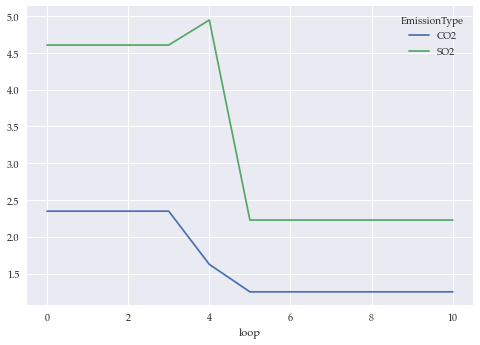

In [17]:
solution['Emissions'].unstack('EmissionType').plot();